In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import pickle
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.metrics import confusion_matrix

"""
plot_history(): reads Keras result and ogenerate figure of Loss, Dice Coefficient, and Accuracy.
"""
def plot_history(history):
    loss_list = [s for s in history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.keys() if 'loss' in s and 'val' in s]
    dice_list = [s for s in history.keys() if 'dice' in s and 'val' not in s]
    val_dice_list = [s for s in history.keys() if 'dice' in s and 'val' in s]
    acc_list = [s for s in history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history[loss_list[0]]) + 1)
    
    ## Loss
    plt.subplot(1,3,1)
    for l in loss_list:
        plt.plot(epochs, history[l], 'b', label='Training loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history[l], 'g', label='Validation loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Dice Coefficient
    plt.subplot(1,3,2)
    for l in dice_list:
        plt.plot(epochs, history[l], 'b', label='Training Dice Coefficient (' + str(format(history[l][-1],'.5f'))+')')
    for l in val_dice_list:    
        plt.plot(epochs, history[l], 'g', label='Validation Dice Coefficient (' + str(format(history[l][-1],'.5f'))+')')

    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    ## Accuracy
    plt.subplot(1,3,3)
    for l in acc_list:
        plt.plot(epochs, history[l], 'b', label='Training accuracy (' + str(format(history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history[l], 'g', label='Validation accuracy (' + str(format(history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


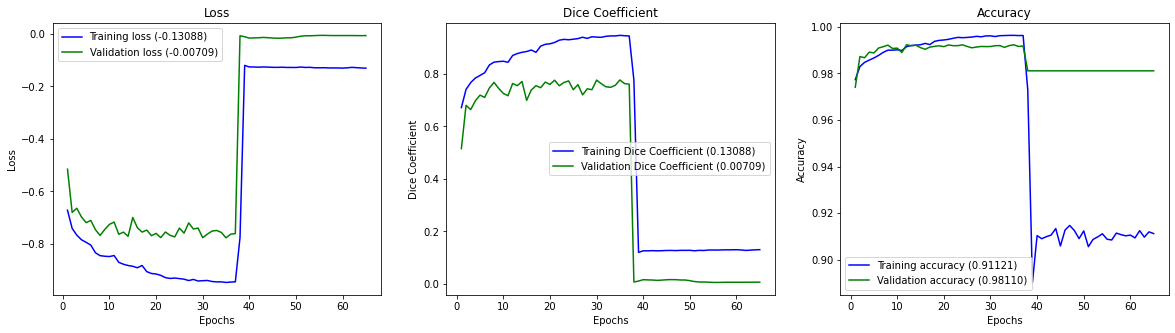

In [3]:
root_path = 'training_results/'
infile = open(root_path+'history_attention2_Notransfered_NoNAIP_20200921-161714.pickle','rb')
new_dict = pickle.load(infile)
infile.close()
plt.figure(figsize=(20,5))
plot_history(new_dict)

Confusion matrix, without normalization
[[100269071   6115780]
 [   501295   1594728]]


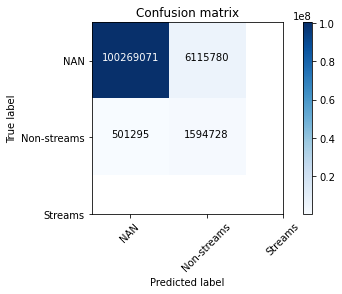

In [8]:
import copy
import random
import sys
import numpy as np

buf =30
"""
plot_confusion_matrix(): prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

preds_test_mod = np.load('Covington_data/without_NAIP/pred_Rowan_mdl_Covington_data.npy')

dim = np.load('Covington_data/Total_data/reference_nodata_as_0.npy').shape
numr = dim[0]//(224 - buf*2)
numc = dim[1]//(224 - buf*2)
count = -1
for i in range(numr):
    for j in range(numc):
#         if(j == 83):
#             print("row: ",i,"column: ",j, "count", count)
#             break    
        count += 1    
        temp = preds_test_mod[count][buf:-buf,buf:-buf]
        if j == 0:
            rows = temp
        else:
            rows = np.concatenate((rows,temp),axis = 1)
    if i == 0:
        prediction_map = copy.copy(rows)
    else:
        prediction_map = np.concatenate((prediction_map,rows),axis = 0)

prediction_map = prediction_map[:,:,0]

# fig= plt.figure(figsize=(20,15))
# plt.imshow(prediction_map*255,cmap='gray',vmin=0, vmax=255)
# plt.show()

#print(np.unique(prediction_map))

# mask
mask = np.load('Covington_data/Total_data/mask.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
[lr,lc] = np.where(mask == 1)

# Read reference data
groundtruthlist = np.load('Covington_data/Total_data/reference_nodata_as_0.npy')[:prediction_map.shape[0],:prediction_map.shape[1]][lr,lc]
predictionlist = prediction_map[lr,lc]

# print(np.unique(groundtruthlist*255))
# print(np.unique(predictionlist))
# print(type(groundtruthlist))
# print(groundtruthlist)
# print(type(predictionlist))
# print(predictionlist)

cm = confusion_matrix((groundtruthlist).astype(int), predictionlist)
plot_confusion_matrix(cm,classes=["NAN","Non-streams","Streams"])

In [9]:
# Statistics
from sklearn.metrics import f1_score, precision_score,recall_score
#print(f1_score(groundtruthlist, predictionlist, average='macro'))
# print('F1 score of nonstream: '+str(f1_score(groundtruthlist, predictionlist,pos_label=0)))
# print('Precision of stream: '+str(precision_score(groundtruthlist, predictionlist,pos_label=1)))
# print('Precision of nonstream: '+str(precision_score(groundtruthlist, predictionlist,pos_label=0)))
# print('Recall of stream: '+str(recall_score(groundtruthlist, predictionlist,pos_label=1)))
# print('Recall of nonstream: '+str(recall_score(groundtruthlist, predictionlist,pos_label=0)))

print('F1 score of Nonstream: '+str(f1_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('F1 score of Stream: '+str(f1_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Precision of Nonstream: '+str(precision_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Precision of Stream: '+str(precision_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Recall of Nonstream: '+str(recall_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Recall of Stream: '+str(recall_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

F1 score of Nonstream: 0.9680574059595128
F1 score of Stream: 0.32523794601781203
Precision of Nonstream: 0.9950253728362959
Precision of Stream: 0.20682528310715714
Recall of Nonstream: 0.9425126797423441
Recall of Stream: 0.7608351625912502


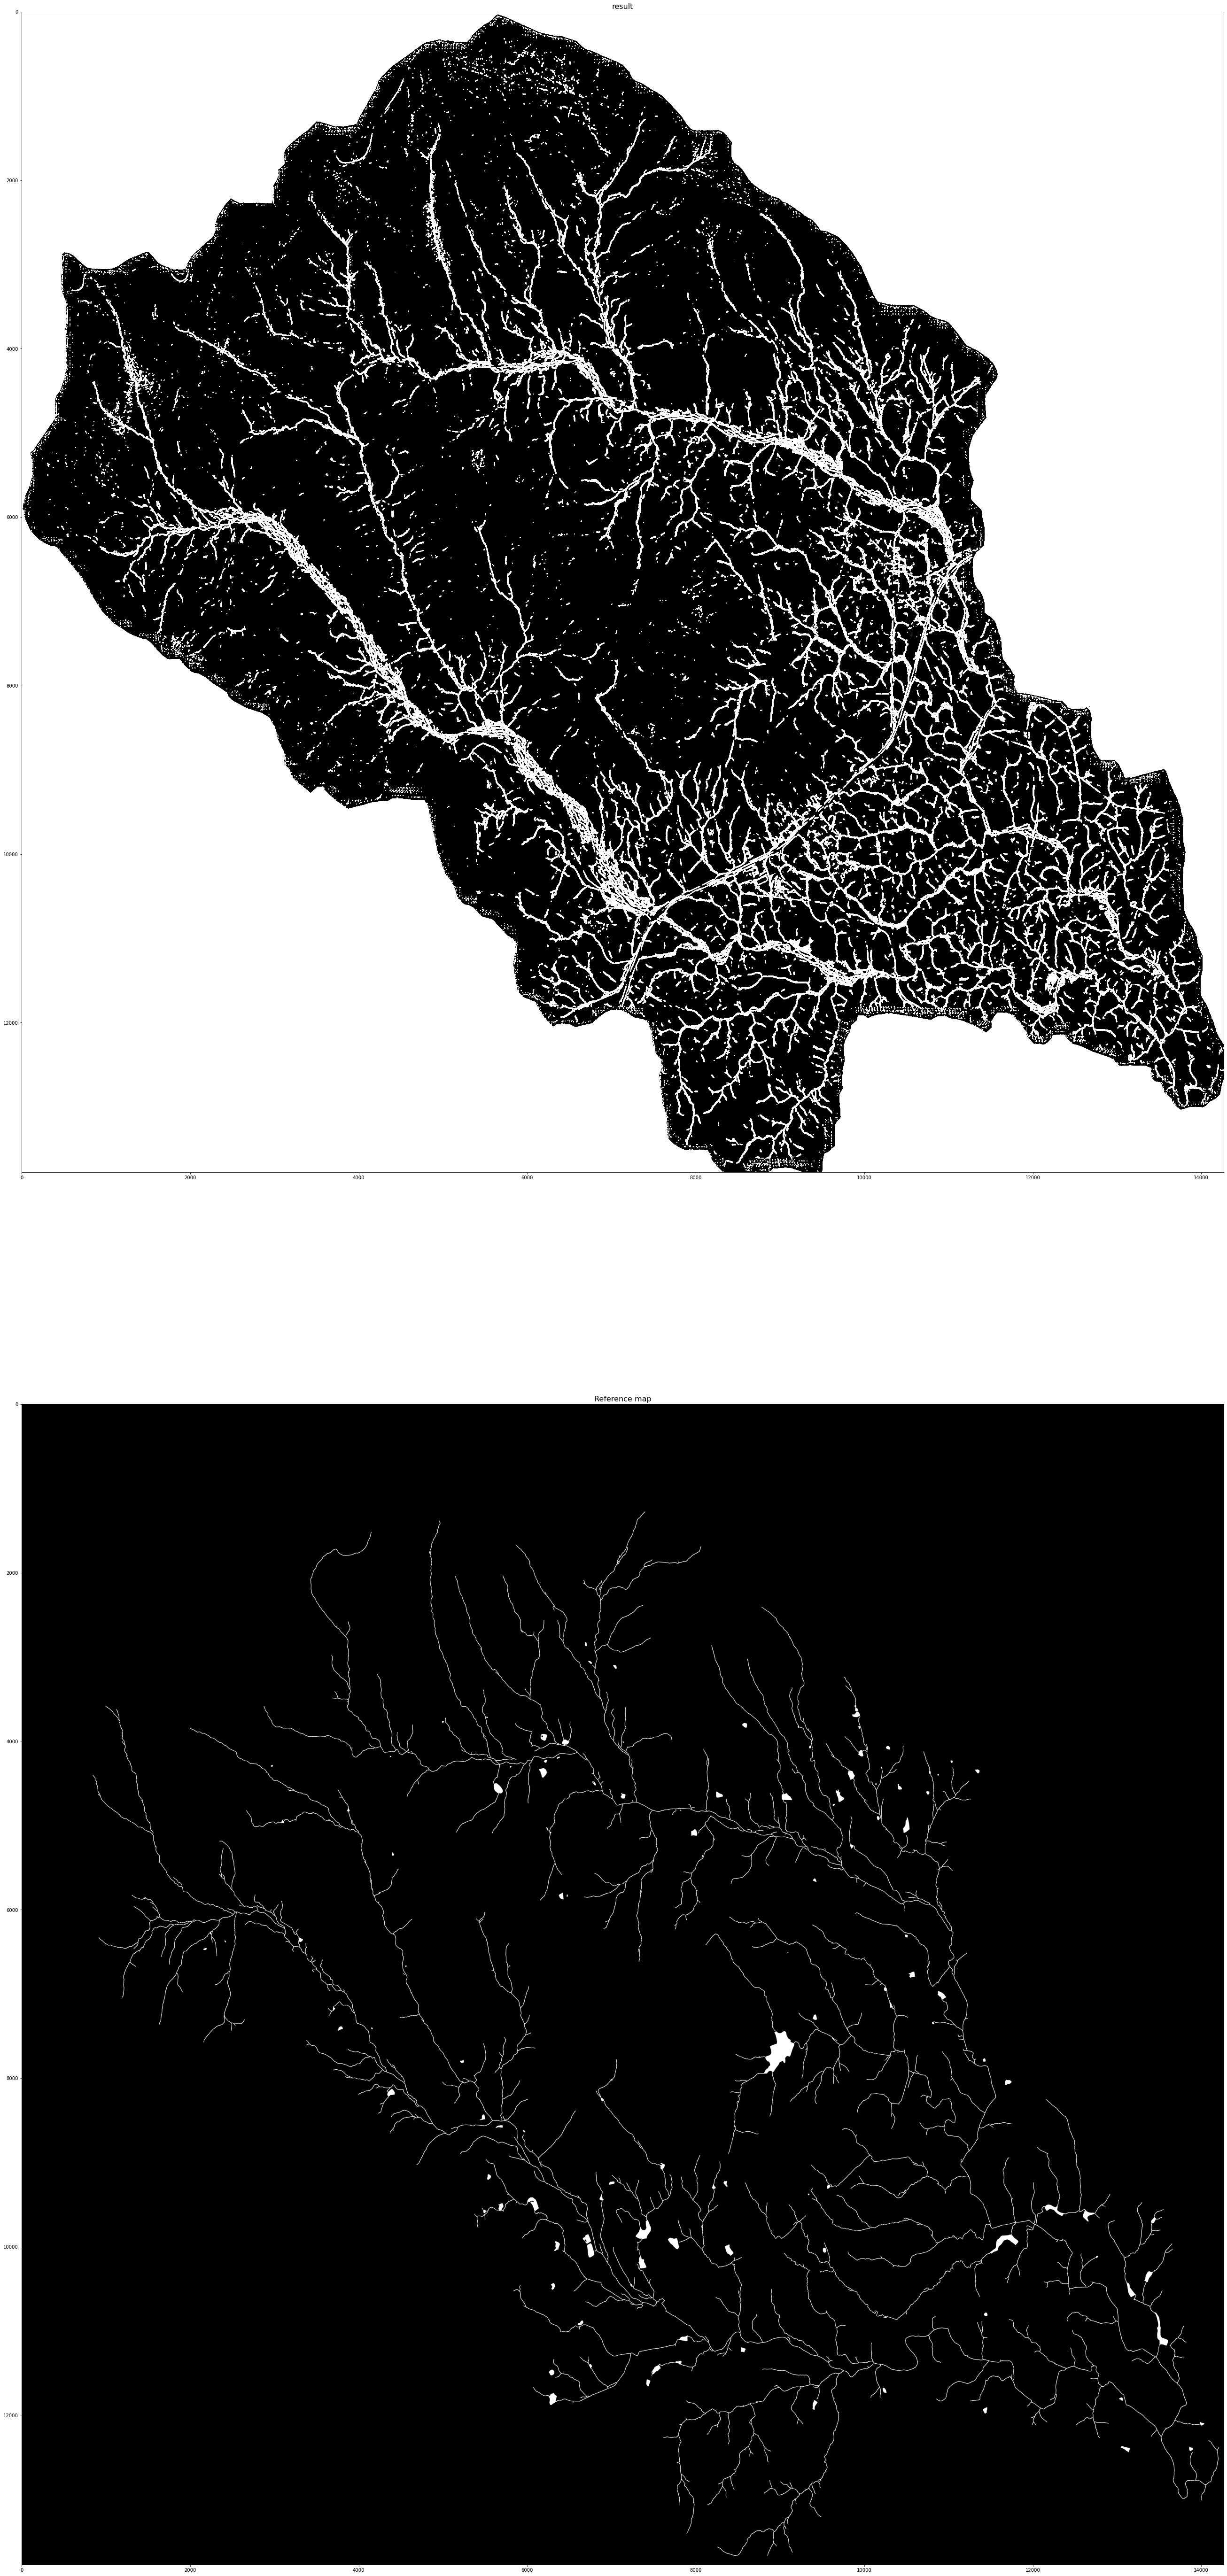

In [10]:
# Generate prediction map
import gdal    
import numpy as np
import numpy.ma as ma
import copy
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(100,100),dpi=72)

# Plot the map
prediction_map_plt = prediction_map
plt.subplot(2,1,1)
plt.title('result',fontsize = 16)
plt.imshow(prediction_map_plt*255,cmap='gray',vmin=0, vmax=1)

reference = np.load('Covington_data/Total_data/reference_nodata_as_0.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
plt.subplot(2,1,2)
plt.title('Reference map',fontsize = 16)
plt.imshow(reference*255,cmap='gray',vmin=0, vmax=255)
plt.show()